In [1]:
import numpy as np
import matplotlib.pyplot as plt
from turb.lesgo_utils import lesgo_data, read_array_from_file, write_array_to_file

ModuleNotFoundError: No module named 'turb'

In [2]:
root_dir = '/home/zyou6474/Projects/lesgo_adjoint_tutorial_bundle/tests/6_validation_test'

dims = [128, 128, 64]
domain = [2*np.pi, np.pi, 1]

ldata = lesgo_data(domain, dims, root_dir, ntheta=3)

t_total = 50000
tstep = 1000
tt = np.arange(0, t_total+1, tstep)

## Temperature Diffusion Setup

### Initial and boundary conditions
The setup of initial and boundary conditions in the original paper are
$$
\begin{aligned}
&\theta_i (x, y, z, 0) = 0.5(1-y^2)\\
& \theta_i (x, -1, z, t) = 0, \quad \theta_i (x, 1, z, t) = 0
\end{aligned}
$$


However, in LESGO, the normal direction is $z$ instead of $y$ and the simulation is running on a half channel. So that the transformed IC and BCs are
$$
\begin{aligned}
&\theta_i (x, \hat{y}, \hat{z}, 0) = 0.5(2\hat{z} - \hat{z}^2 )\\
& \theta_i (x, \hat{y}, \hat{z}=0, t) = 0, \quad \frac{\partial \theta_i}{\partial \hat{z}} (x, \hat{y}, \hat{z}=1, t) = 0
\end{aligned}
$$
which is based on 
$$
\hat{z} = y+1,\quad \forall y \in [-1, 0] \quad \& \quad \hat{y} = z, \quad\forall z \in [0, \pi].
$$

In [3]:
Pr_list = [0.1, 0.71, 2]
Re = 180
RePr = Re*np.array(Pr_list)

Text(0, 0.5, 'T')

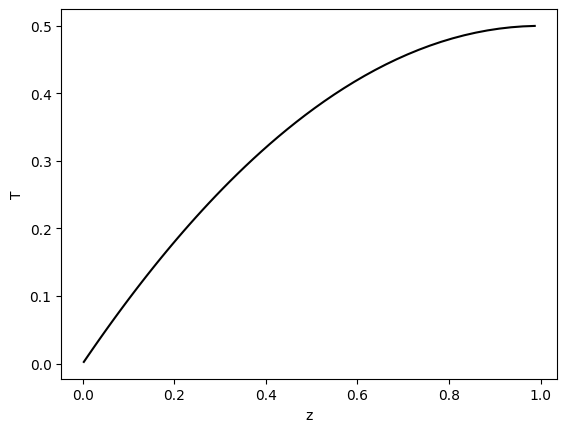

In [4]:
xc, yc, zc = ldata.coords

xx, yy, zz = np.meshgrid(xc, yc, zc, indexing='ij')

theta = 0.5 * (2*zz - zz**2)
fig, ax = plt.subplots()
ax.plot(zc, theta[0, 0, :], color='black')
ax.set_xlabel('z')
ax.set_ylabel('T')

In [5]:
ldata.set_adjoint(fmt_ntheta='%.3i')
fname = ldata.inputs_dir + '/theta.IC.'+ldata.fmt_kwargs['fmt_ntheta']
figs = []
[figs.append(write_array_to_file(fname % (i + 1), theta, gen_fig=False, domain=ldata.domain, dims=ldata.dims,)) for i in range(ldata.ntheta)]

write data into /home/zyou6474/Projects/lesgo_adjoint_tutorial_bundle/tests/6_validation_test/inputs/theta.IC.001
write data into /home/zyou6474/Projects/lesgo_adjoint_tutorial_bundle/tests/6_validation_test/inputs/theta.IC.002
write data into /home/zyou6474/Projects/lesgo_adjoint_tutorial_bundle/tests/6_validation_test/inputs/theta.IC.003


[None, None, None]

## Source

According to Kim's work{cite}`kimTransportPassiveScalars1989`, they also has a continuous source term inside the channel, 
$$
\begin{equation}
Q_i = \frac{2}{\text{Re}\text{Pr}_i}.
\end{equation}
$$

In [6]:
source = []

for Pr in Pr_list:
    source.append(zz*0 + 1/Re/Pr)
    print('%.4f amount of scalar is generated at each point' % (1/Re/Pr))

0.0556 amount of scalar is generated at each point
0.0078 amount of scalar is generated at each point
0.0028 amount of scalar is generated at each point


In [7]:
fname = ldata.inputs_dir + '/source.' + ldata.fmt_kwargs['fmt_ntheta']
figs = []
[figs.append(write_array_to_file(fname % (i + 1), source[0], gen_fig=False, )) for i in range(ldata.ntheta)]

write data into /home/zyou6474/Projects/lesgo_adjoint_tutorial_bundle/tests/6_validation_test/inputs/source.001
write data into /home/zyou6474/Projects/lesgo_adjoint_tutorial_bundle/tests/6_validation_test/inputs/source.002
write data into /home/zyou6474/Projects/lesgo_adjoint_tutorial_bundle/tests/6_validation_test/inputs/source.003


[None, None, None]

## Stability check

Plot friction Reynolds number $Re_{\tau}$ in time series to check if the simulation is stabilized, 
$$
Re_{\tau} = \frac{u_{\tau}\delta}{\nu} = \frac{\delta}{\delta_{\nu}},
$$
which is determined by the characteristic velocity scale -- friction velocity $u_{\tau} = \sqrt{\frac{\tau_{w}}{\rho}}$ and characteristic length scale -- viscous length scale $\delta_{\nu} = \frac{\nu}{u_{\tau}}$. [^wall_shear_stress]

[^wall_shear_stress]: Wall shear stress $\tau_w = \rho\nu \left( \frac{\mathrm{d} \langle U\rangle}{\mathrm{d} y} \right)_{y=0}$ .

In our setting, the characteristic velocity scale $u_{\tau}=1m/s$ (u_star in `lesgo.conf`), characteristic length scale $\delta= 1m$ (z_i in `lesgo.conf`) and molecular viscosity $\nu = 0.00556 m^2/s$ (nu_molec in `lesgo.conf`).

In [8]:
u_tau = 1
z_i = 1
nu = 0.00556

Since LESGO's streamwise velocity is located at center of uv-grid, so that we calculate the velocity gradient by
$$
\left( \frac{\mathrm{d} \langle U\rangle}{\mathrm{d} y} \right)_{y=0} = U_{k=1} / z_{k=1}
$$

In [9]:
# Check Re_tau
Re_tau = []
for t_ind, t in enumerate(tt):
    ldata.read_data(t)
    u_average = np.average(ldata.data['u'], axis = (0, 1))
    u_tau_actual = np.sqrt(nu * (u_average[0])/ldata.coords[2][0])
    Re_tau.append(u_tau_actual*z_i / nu)
    delta_nu = nu / u_tau_actual

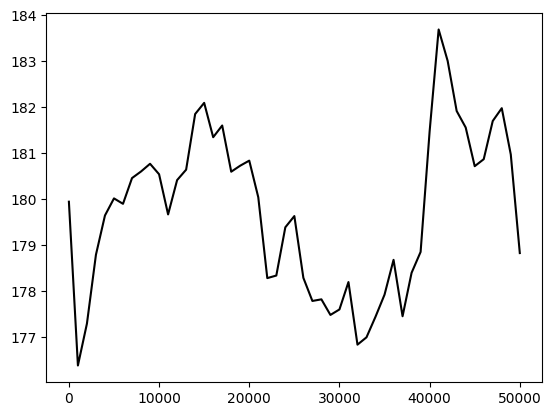

In [10]:
plt.plot(tt, Re_tau, color='black')

We could see that the friction Reynolds number is stabilized around 180.

## Velocity Validation

Validate the velocity profile with previous research data from {cite}`leeDirectNumericalSimulation2015`. Data can be downloaded from this [link](https://turbulence.oden.utexas.edu/data/MKM/chan180/profiles/chan180.means).

In [11]:
valid_vf = r'./chan180.means'

# Read in validate velocity
tmp = []
with open(valid_vf, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.replace('\n', '')
        if line.startswith('##'):
            keys = line.split()[1:]
        elif not line.startswith('#'):
            tmp.append([float(d) for d in line.split()])

print(keys)
chan180 = {}
for ind, key in enumerate(keys):
    chan180[key] = np.array(tmp)[:, ind]

['y', 'y+', 'Umean', 'dUmean/dy', 'Wmean', 'dWmean/dy', 'Pmean']


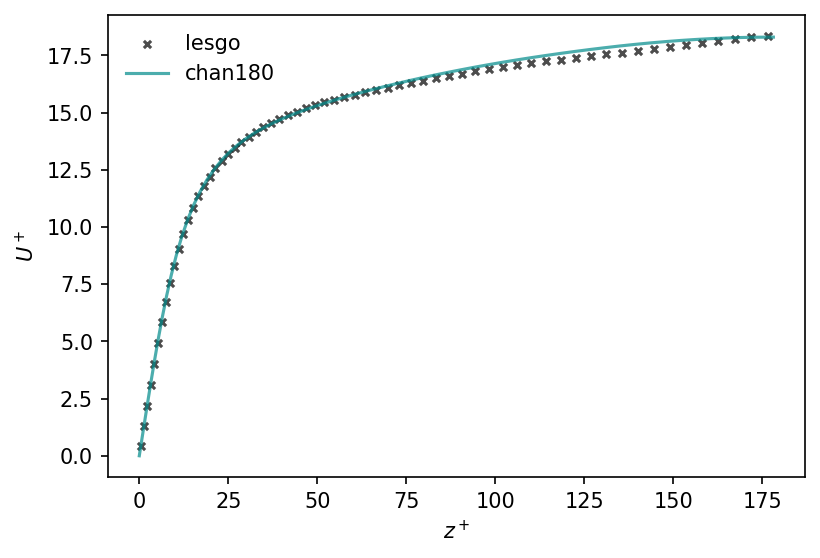

In [12]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.scatter(ldata.coords[2]/delta_nu, u_average, marker='x', s = 12, color='black', label='lesgo', alpha=0.7)
ax.plot(chan180['y+'], chan180['Umean'], color='darkcyan', label='chan180', alpha=0.7)
ax.set_xlabel('$z^+$')
ax.set_ylabel('$U^+$')
ax.legend(frameon=False)

## Reynolds stress Validation
Validate the Reynolds stress profile with previous research data from {cite}`leeDirectNumericalSimulation2015`. Data can be downloaded from this [link](https://turbulence.oden.utexas.edu/data/MKM/chan180/profiles/chan180.reystress).

[Working On]

(<Figure size 800x400 with 4 Axes>,
 [<Axes: xlabel='x', ylabel='y'>,
  <Axes: xlabel='x', ylabel='z'>,
  <Axes: xlabel='y', ylabel='z'>])

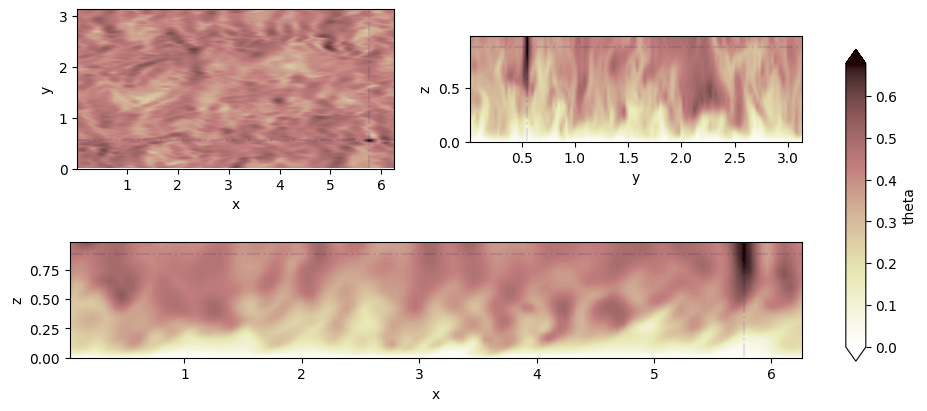

In [13]:
ldata.read_data(t_total)
from pyutils.plot_utils import contour_channel
contour_channel(ldata.coords, ldata.data['theta'][0])

## Temperature Validation
Validation based on previous literature{cite}`kimTransportPassiveScalars1989`.


In [14]:
data_f = r'/home/zyou6474/Projects/ERI/notebooks/lesgo/tests/Kim_data.txt'

z_kim = []
T_kim = []
tmp = []
x_tmp = []
with open(data_f) as f:
    lines = f.readlines()
    for line in lines:
        line = line.replace('\n', '')
        if line.startswith('%DATA'):
            if len(tmp)>1: T_kim.append(tmp); z_kim.append(x_tmp)
            tmp = []
            x_tmp = []
            continue
        d = line.split(', ')
        x_tmp.append(float(d[0]))
        tmp.append(float(d[1]))
    T_kim.append(tmp); z_kim.append(x_tmp)

### Scalar Normalization

Passive scalars are non-dimensionalized by the wall surface scalar flux defined as
$$
\theta_{\tau} = \frac{\dot{q}_w}{\rho c_p u_\tau} = \frac{k \frac{\partial \theta}{\partial z}|_w}{\rho c_p u_\tau} = \frac{\alpha \frac{\partial \theta}{\partial z}|_w}{u_\tau},
$$
where $\rho$ and $c_p$ are the fluid density and the specific heat at constant pressure respectively, and $\alpha = k/(\rho c_p)$. [^thermal_diffusivity]

[^thermal_diffusivity]: Thermal diffusivity $\alpha$ satisfies $Pr = \nu / \alpha$.

The surface heat flux $\theta_\tau$ is sometimes referred as the friction temperature in analogy to the friction velocity, $u_\tau$. Furthermore, the non-dimensionalized passive scalar is $\theta^+ = \theta / \theta_{\tau}$.

In order to see if the scalar field is stabilized, maybe we could also plot the variation of friction temperature as a reference.

In [15]:
theta_tau = np.empty(shape = (ldata.ntheta, len(tt)))
for t_ind, t in enumerate(tt):
    ldata.read_data(t)
    for nk in range(ldata.ntheta):
        theta_average = np.average(ldata.data['theta'][nk], axis = (0, 1))
        theta_gradient = theta_average[0]/zc[0]
        theta_tau[nk, t_ind] = (theta_gradient/RePr[nk])

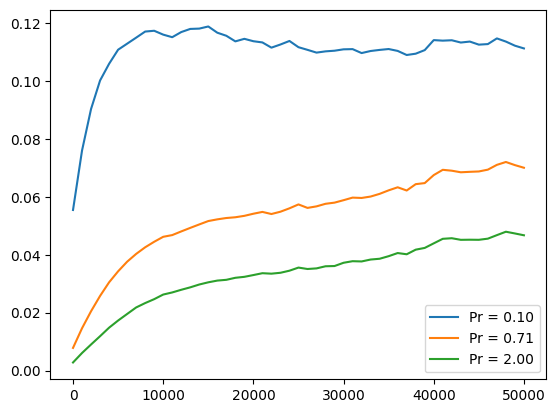

In [16]:
[plt.plot(tt, theta_tau[nk], label='Pr = %.2f' % Pr_list[nk]) for nk in range(ldata.ntheta)]
plt.legend()

In [17]:
z_plus = np.empty(shape=(0, len(zc)))
theta_plus = np.empty(shape=(0, theta.shape[2]))
for nk in range(ldata.ntheta):
    theta_bar = np.average(ldata.data['theta'][nk], axis=(0, 1))
    theta_gradient = theta_bar[0]/zc[0]
    print(theta_gradient)
    theta_tau = theta_gradient/RePr[nk]

    z_plus = np.vstack((z_plus, zc*Re))
    theta_plus = np.vstack((theta_plus, theta_bar /theta_tau))

2.0042192299252872
8.957819486432244
16.82933493966084


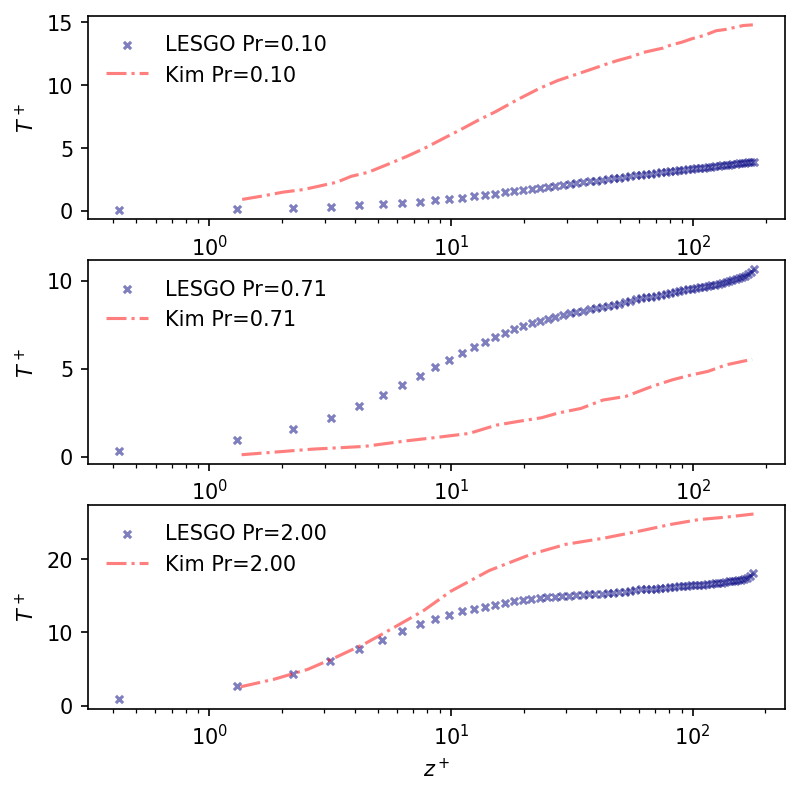

In [18]:
fig, axes = plt.subplots(ldata.ntheta, 1, figsize = (6, 6), dpi=150)
for nk in range(ldata.ntheta):
    axes[nk].scatter(z_plus[nk], theta_plus[nk], s= 12, marker='x', color='navy', alpha=0.5, label='LESGO Pr=%.2f' % Pr_list[nk])
    axes[nk].plot(z_kim[nk], T_kim[nk], linestyle='-.', color='red', alpha=0.5, label='Kim Pr=%.2f' % Pr_list[nk])

    axes[nk].legend(frameon=False)
    axes[nk].set_xlabel('$z^+$')
    axes[nk].set_ylabel('$T^+$')
    axes[nk].set_xscale('log')
    # axes[nk].set_yscale('log')